# Predicting COVID-19 Cases From County Health Data

*Author: John-Wesley Appleton*

# Introduction

An accurate count of new daily cases of COVID-19 is important for resource allocation and policy
making at the county, state, and federal levels. We seek to provide an accurate prediction of new daily cases of COVID-19 at the county-level for those counties which do not have the resources nor the facilities to test and report the actual number of new daily cases.


We will attempt to predict the daily increase in COVID-19 cases in American counties by using:
1. [A New York Times dataset of county-level COVID-19 cases and deaths](https://github.com/nytimes/covid-19-data)
2. [A County Health Rankings and Roadmaps dataset of measurements of county-level health factors](https://www.countyhealthrankings.org/explore-health-rankings/rankings-data-documentation)

# Import Libraries and Data

Let's begin by importing the libaries we'll be using.

In [ ]:
# make imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from google.colab import drive

Let's mount our Google Drive so that we can access our data.

In [ ]:
# mount to drive
prefix = '/content/drive'
from google.colab import drive
drive.mount(prefix)

Mounted at /content/drive


We can now import our datasets.

In [ ]:
# create path to csv files
covid_path = '/content/drive/My Drive/CIS_520_Final_Project/us-counties-2020.csv'
county_health_path = '/content/drive/My Drive/CIS_520_Final_Project/county-health-rankings-data-2020.csv'

In [ ]:
# read csv files
covid_df = pd.read_csv(covid_path)
county_health_df = pd.read_csv(county_health_path, skiprows=[1])

Let's take a look at our first dataset: the New York Times COVID-19 data. Let's see how much data we have and how the first 5 rows look.

In [ ]:
# view covid df
print(covid_df.shape)
covid_df.head()

(884737, 6)


,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


Great! Now let's do the same with the County Health Rankings and Roadmaps Dataset.

In [ ]:
# view county health df
print(county_health_df.shape)
county_health_df.head()

(3194, 786)


,State FIPS Code,County FIPS Code,5-digit FIPS Code,State Abbreviation,Name,Release Year,County Ranked (Yes=1/No=0),Premature death raw value,Premature death numerator,Premature death denominator,...,Male population 18-44 raw value,Male population 45-64 raw value,Male population 65+ raw value,Total male population raw value,Female population 0-17 raw value,Female population 18-44 raw value,Female population 45-64 raw value,Female population 65+ raw value,Total female population raw value,Population growth raw value
0,0,0,0,US,United States,2020,NaN,6940.110519,3813889.0,912286150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,1000,AL,Alabama,2020,NaN,9942.794666,81791.0,13640424.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,1001,AL,Autauga County,2020,1.0,8128.591190,791.0,155856.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,3,1003,AL,Baldwin County,2020,1.0,7354.122530,2967.0,588433.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,1005,AL,Barbour County,2020,1.0,10253.573403,472.0,70435.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Wow! We have a lot of data! There are a couple of problems with these datasets, however:

1. The COVID data contains cumulative case counts. We want daily case counts.
2. The county health data contains a lot of null values. We don't like those.
3. There are a lot of features that we don't want to keep. For example, it doesn't make sense for us to keep the county name as a feature!
4. There are some categorical features that we want to keep. We'll need to one-hot encode those ones.

This seems like it would be a lot of work! Luckily for you, we already did all these steps so that you don't need to! Let's import this clean dataset.

In [ ]:
# create path to partial csv file
data_path = '/content/drive/My Drive/CIS_520_Final_Project/partial_data.csv'

In [ ]:
# read data files
data_df = pd.read_csv(data_path)

Oh! One more thing... this is only 5% of the dataset! After performing the pre-processing, we had way to much data and so we'll only use 5%.

Let's see what it looks like.

In [ ]:
# view data
print(data_df.shape)
data_df.head()

(32472, 170)


,cases_0,cases_1,deaths_1,cases_2,deaths_2,cases_3,deaths_3,cases_4,deaths_4,cases_5,...,['State Abbreviation']_UT,['State Abbreviation']_VA,['State Abbreviation']_VT,['State Abbreviation']_WA,['State Abbreviation']_WI,['State Abbreviation']_WV,['State Abbreviation']_WY,['Premature death flag (0 = No Flag/1=Unreliable/2=Suppressed)']_0,['Premature death flag (0 = No Flag/1=Unreliable/2=Suppressed)']_1,['Premature death flag (0 = No Flag/1=Unreliable/2=Suppressed)']_2
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,...,0,0,0,0,0,0,0,1,0,0
1,6.0,10.0,0.0,10.0,0.0,9.0,0.0,17.0,0.0,4.0,...,0,0,0,0,0,0,0,1,0,0
2,152.0,149.0,3.0,192.0,6.0,110.0,9.0,113.0,8.0,122.0,...,0,0,0,0,0,0,0,1,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,8.0,22.0,0.0,12.0,0.0,12.0,0.0,17.0,1.0,9.0,...,0,0,0,0,0,0,0,1,0,0


Great! Let's get to work now!

# Exploratory Data Analysis

Before we get to work, let's check the distributions of our variables. We'll start with our response.

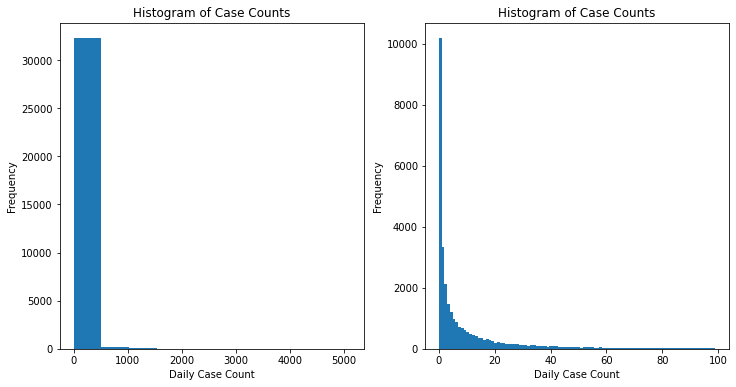

In [ ]:
# view the distribution of cases 
cases = data_df['cases_0']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(cases, 10)
ax1.set_xlabel('Daily Case Count')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Case Counts')

ax2.hist(cases[cases<100], 100)
ax2.set_xlabel('Daily Case Count')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Case Counts')

plt.show()

Uhhh that's not a good sign. What's the distribution of this variable?

In [ ]:
# describe label
data_df['cases_0'].describe()

count    32472.000000
mean        25.030734
std        112.887106
min          0.000000
25%          0.000000
50%          3.000000
75%         14.000000
max       5117.000000
Name: cases_0, dtype: float64

Hmm that's not good. This task will be hard. Let's look at the distribution of daily death counts.

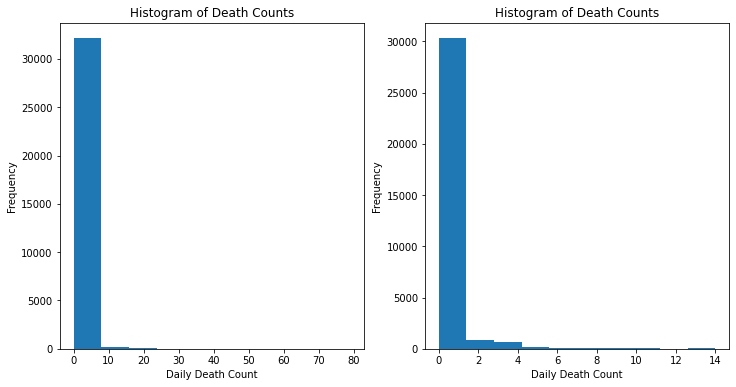

In [ ]:
# view the distribution of deaths 
deaths = data_df['deaths_1']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(deaths, 10)
ax1.set_xlabel('Daily Death Count')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Death Counts')

ax2.hist(deaths[deaths<15], 10)
ax2.set_xlabel('Daily Death Count')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Death Counts')

plt.show()

Hmm. That's interesting. What about the raw value features? Let's pick one randomly.

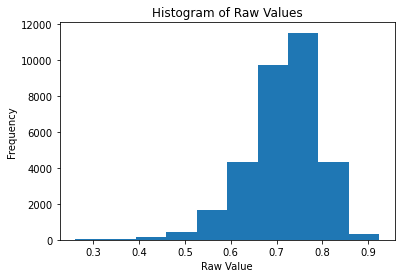

In [ ]:
# view the distribution of raw values 
owner = data_df['Homeownership raw value']

plt.hist(owner)
plt.xlabel('Raw Value')
plt.ylabel('Frequency')
plt.title('Histogram of Raw Values')

plt.show()

Ahhh! Finally something that's approximately normal.

Let's continue our work now.

# Split Train and Test Data

Let's split our data into training and testing datasets.

In [ ]:
# split data
data_np = data_df.to_numpy()
X = data_np[:, 1:]
y = data_np[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Modeling

Let's do some modeling! You might have seen that we imported scikit-learn's Ridge regression package, but don't worry, we'll do something more exciting. We're doing stepwise regression!

Why stepwise regression? Well, we have a lot of features! I'm sure some are important, but most are probably useless. We want to use a model that will perform feature selection for us, and it just so happens that stepwise regression is good at that very task.

Why didn't we import some stepwise regression package from scikit-learn? Well, unfortunately, people are too focused on the next big neural network, and no one has taken the time to create a stepwise regression package for us.

That's fine though, it's pretty easy to implement. The first thing we will do is implement a function called ```update_model```.



In [ ]:
def update_model(model, mae, incl_features, X_train, y_train, X_test, y_test):
    ''' Inputs:
            model -> best model so far
            mae -> best mae so far
            incl_features -> indices of features included in the current model
            X_train -> train features
            y_train -> train labels
            X_test -> test features
            y_test -> test labels
        
        Outputs:
            model -> best model found
            mae -> best mse found
            incl_features -> indices of features included in the best model found
    '''
    to_try = [x for x in range(len(X_train[0])) if x not in incl_features]
    best_feature = None
    for x in to_try:
        if len(incl_features) == 0:
            rdg = Ridge().fit(X_train[:, x].reshape(-1, 1), y_train)
            y_test_pred = rdg.predict(X_test[:, x].reshape(-1, 1))
        else:
            features = np.sort(incl_features + [x]).tolist()
            rdg = Ridge().fit(X_train[:, features].reshape((X_train.shape[0], len(features))), y_train)
            y_test_pred = rdg.predict(X_test[:, features].reshape((X_test.shape[0], len(features))))

        rdg_test_mae = mean_absolute_error(y_test, y_test_pred)
        if rdg_test_mae < mae:
            mae = rdg_test_mae
            model = rdg
            best_feature = x
    
    if best_feature != None:
        if len(incl_features) == 0:
            incl_features = [best_feature]
        else:
            incl_features = incl_features + [best_feature]

    return model, mae, incl_features

Great! Now let's use it to implement stepwise regression. Implement ```stepwise_regression```.

In [ ]:
def stepwise_regression(X_train, y_train, X_test, y_test, tol):
    ''' Inputs:
            X_train -> train features
            y_train -> train labels
            X_test -> test features
            y_test -> test labels
            tol -> tolerance
        
        Outputs:
            model -> best model found

    '''
    losses = []
    prev_incl_features = None
    incl_features = []
    order_added = []
    model = Ridge().fit(np.ones((y_train.shape[0], 1)), y_train)
    y_test_pred = model.predict(np.ones((y_test.shape[0], 1)))
    mae = mean_absolute_error(y_test, y_test_pred)

    while len(losses) == 0 or (prev_incl_features != incl_features and losses[-1] - mae >= tol):
        prev_incl_features = incl_features
        losses.append(mae)
        model, mae, incl_features = update_model(model, mae, incl_features, X_train, y_train, X_test, y_test)
        order_added = order_added + [incl_features[-1]]
    
    losses.append(mae)

    return model, order_added, losses

Cool! Let's use it! We'll use a tolerance of 0.01 because, for our usage, we don't really need it to be accurate than that.

In [ ]:
# train and test stepwise regression
stp, order_added, losses = stepwise_regression(X_train[:int(X_train.shape[0] * 0.8)], y_train[:int(X_train.shape[0] * 0.8)], X_train[int(X_train.shape[0] * 0.8):], y_train[int(X_train.shape[0] * 0.8):], .01)

to_select = np.sort(order_added).tolist()
stp = Ridge().fit(X_train[:, to_select].reshape((X_train.shape[0], len(to_select))), y_train)

y_train_pred = stp.predict(X_train[:, to_select].reshape((X_train.shape[0], len(to_select))))
y_test_pred = stp.predict(X_test[:, to_select].reshape((X_test.shape[0], len(to_select))))

stp_train_mae = mean_absolute_error(y_train, y_train_pred)
stp_test_mae = mean_absolute_error(y_test, y_test_pred)

print('Inlcuded features are: %s' % order_added)
print('Train MAE is: %s' % stp_train_mae)
print('Test MAE is: %s' % stp_test_mae)

Inlcuded features are: [12, 0, 10, 8, 105, 2, 6, 116, 4]
Train MAE is: 11.080777694899679
Test MAE is: 11.325592150929861


Wow! Pretty cool! Let's visualize some predictions!

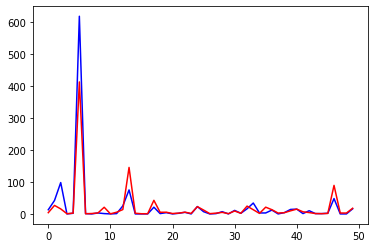

In [ ]:
# visualize predictions
plt.plot(y_test[:50], color='blue')
plt.plot(y_test_pred[:50], color='red')
plt.show()

Awesome! It seems like it's able to follow the trend pretty well. It's not perfect, but not terrible. One of the outputs of our model was the features included in our model. We see that the following features were added, in this order:

1. Case increase 7 days ago
2. Case increase 1 days ago
3. Case increase 6 days ago
4. Case increase 5 days ago
5. Population raw value
6. Case increase 2 days ago
7. Case increase 4 days ago
8. Percent rural raw value
9. Case increase 3 days ago

Pretty cool! Let's see how the loss changes as we added each feature.

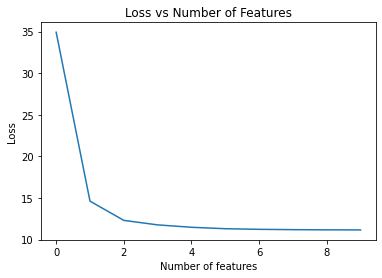

In [ ]:
# visualize losses
plt.plot(losses)
plt.xlabel('Number of features')
plt.ylabel('Loss')
plt.title('Loss vs Number of Features')
plt.show()

# Conclusion

Even though there were some significant challenges with our data, notable the distribution of our features and label, we see that we were able to make some pretty good predictions!

One of the reasons why stepwise regression works well in this case is because it does a great job of feature selection. We started with 169 features, yet, our model only chose 9.

Hopefully you enjoyed this notebook and you learned something new!